In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import nivapy3 as nivapy
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score
from sklearn.feature_selection import RFECV
from collections import OrderedDict

plt.style.use('ggplot')

# Feature importances for WaterXr

Rough code for estimating feature importances using a Random Forest. The most complicated part of this workflow is deciding how to handle NaNs in a sensible way. This is because the sampling strategy at Vansjø is strongly biased over time (sampling only takes place between spring and autumn). This produces regular periods of NaNs in the data series, which affect the calculations for lagged variables.

## 1. Read data

In [2]:
# Variable of interest. Choose from 'TP', 'Chl-a', 'CyanoBiovol'. These need to match the data matrix file names
variable = 'TP'

# Basin of interest. Choose from 'Van1' (Storefjorden) or 'Van2' (Vanemfjorden)
basin = 'Van1'

# Dict to translate from variable name used in filename, to that used in column name for picking out target var
target_var_dict = {'TP':'tp_lake',
                  'Chl-a': 'chl-a_lake',
                  'CyanoBiovol': 'CyanoBiovol'}

target_var = target_var_dict[variable]

# Read Leah's data matrix
in_csv = r'../data/DataMatrices/dataMatrix_monthly_%s_%s.csv' %(variable, basin)
df = pd.read_csv(in_csv)

# Parse dates and tidy
df['Date'] = pd.to_datetime(df['Date'])
df.columns = df.columns.str.lower()
df.set_index('date', inplace=True)

df.head()

,pptn,temp,q,tp_catch,tp_lake,rel_res_time,rain_day,pptn_intense,pptn_lag1m,temp_lag1m,...,tp_catch_lag2m_av,tp_catch_lag3m_av,temp_lag2m_av,temp_lag3m_av,q_lag2m_av,q_lag3m_av,rel_res_time_lag2m_av,rel_res_time_lag3m_av,season,tp_lake_prevsummer
date,,,,,,,,,,,,,,,,,,,,,
1980-03-31,36.902469,-4.001408,0.365793,NaN,39.500000,2.937803,18,1,33.537067,-9.190934,...,NaN,NaN,-8.641157,NaN,2.247682,NaN,1.677279,NaN,spr,NaN
1980-04-30,10.553205,4.218885,10.717172,130.0,53.559028,0.168976,10,0,36.902469,-4.001408,...,NaN,NaN,-6.596171,-7.094574,0.355697,1.620386,2.973641,2.097454,spr,NaN
1980-05-31,59.362142,11.237943,4.432067,50.0,67.075000,0.287349,12,4,10.553205,4.218885,...,NaN,NaN,0.108739,-2.991152,5.541483,3.809522,1.553389,2.038752,spr,NaN
1980-06-30,131.738069,15.539921,4.893233,80.0,24.444444,0.264810,25,6,59.362142,11.237943,...,90.0,NaN,7.728414,3.818473,7.574620,5.171677,0.228162,1.131376,summ,NaN
1980-07-31,51.099007,16.605522,3.487091,75.0,22.888889,0.435075,26,1,131.738069,15.539921,...,65.0,86.666667,13.388932,10.332250,4.662650,6.680824,0.276079,0.240378,summ,NaN


## 2. Encode variables

In addition to continuous variables, we also have two kinds of categorical variable: **ordinal** and **nominal**. Ordinal data consists of *ordered* classes, such as water quality status where e.g. `'HG'` represents higher quality than `'M'`, which is higher than `'PB'`. The nominal categories are *unordered* (month and season, for example). 

### 2.1. Ordinal data

I will reclassify water quality status using an integer scale, where 0 corresponds to `'PB'` and 2 corresponds to `'HG'`.

In [3]:
# Category mappings
status_dict = {'HG':2,
               'M':1,
               'PB':0}

# Columns with ordinal data
ord_cols = ['status_tp_lake', 'status_tp_lake_lag1m', 'status_tp_lake_prevsummer']

# # Reclassify
# for col in ord_cols:
#     df[col] = df[col].replace(status_dict)

### 2.2. Nominal

The nominal data can be represented using "[one hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)", which generates $(n - 1)$ binary features from a column with $n$ categories.

In [4]:
# One hot encoding for nominal columns
df = pd.get_dummies(df, 
                    {'month':'month',
                     'season':'season',
                     'season_2':'season2'},
                    columns=['month', 'season', 'season_2'],
                    drop_first=True)

## 3. Filling missing data

Most ML algorithms don't like missing data. The code below calculates the proportion of missing values in each column.

In [5]:
# Pct missing
missing = pd.DataFrame(df.isnull().sum()).rename(columns = {0: 'total'})
missing['percent'] = 100 * missing['total'] / len(df)
missing.sort_values('percent', ascending=False).head(20)

,total,percent
q_lag3m_av,49,24.257426
rel_res_time_lag3m_av,49,24.257426
rel_res_time_lag2m_av,45,22.277228
q_lag2m_av,45,22.277228
tp_lake_lag1m,44,21.782178
q_lag1m,42,20.792079
rel_res_time_lag1m,42,20.792079
q,41,20.297030
rel_res_time,41,20.297030
tp_catch_lag3m_av,38,18.811881


Filling these gaps sensibly is not easy. In the code below, I've used the following strategy:

 1. For **continuous** variables, fill missing values with the *median* for the month in question
 
 2. For **Ordinal** variables, fill missing values with the most common (i.e. modal) value for the month in question
 
There are no missing values for the **nominal** variables, since they're all derived from the date-time index, which is complete.

**Note:** Filling NaNs in this way transfers information between samples (i.e. rows) in the dataset. This violates the assumption that each row can be treated as an independent sample and may bias the model evaluation performed below. Ideally, we would retain a completely independent testing dataset for final model evaluation, but we don't have enough data for that here.

In [6]:
# loop over columns
for col in df.columns:
    if col in ord_cols:
        # Ordinal data. Get modal value for each month
        patch = df.groupby(df.index.month)[col].apply(pd.Series.mode).loc[:, 0]

    else:
        # Contiuous data. Get median value for each month
        patch = df.groupby(df.index.month)[col].median()
        
    # Loop over rows
    for idx, row in df.iterrows():
        if pd.isnull(row[col]):
            try:
                # Try to fill with patches value for this month
                fill_val = patch.loc[idx.month]
                df.loc[idx, col] = fill_val
            except KeyError:
                # No data available for this month. Leave as NaN
                pass

How effective has this startegy been at filling NaNs?

In [7]:
# Pct missing
missing = pd.DataFrame(df.isnull().sum()).rename(columns = {0: 'total'})
missing['percent'] = 100 * missing['total'] / len(df)
missing.sort_values('percent', ascending=False).head(10)

,total,percent
tp_lake_lag1m,8,3.960396
tp_catch,1,0.495050
tp_catch_lag2m_av,1,0.495050
tp_catch_lag3m_av,1,0.495050
tp_catch_lag1m,1,0.495050
pptn,0,0.000000
tp_lake_prevsummer,0,0.000000
pptn_intense_lag4m_sum,0,0.000000
pptn_intense_lag5m_sum,0,0.000000
pptn_intense_lag6m_sum,0,0.000000


This is better. For the remaining NaNs, I could either fill values using the overall mean/median for each column, or simply drop the rows that still contain NaN. After a bit of experimentation, I think the best option is to drop the NaNs, rather than apply more arbitrary data patching.
 
## 4. Random forest modelling

### 4.1. Drop any remaining NaNs

In [8]:
df2 = df.dropna(how='any')
print('Length of original dataset:', len(df))
print('Length of trimmed dataset: ', len(df2))

Length of original dataset: 202
Length of trimmed dataset:  194


### 4.2. Fit model


In [9]:
# Define response vars (target variable defined at the start)
exp_vars = [i for i in df2.columns if i != target_var]


Random Forests use "bootstrapping" to partition the data used by each tree. Data not included in each bootstrap sample can therefore be used to perform "internal" validation, without the need for a holdout dataset as is usual for cross-validation. This approach is usually referred to as the "out-of-bag" (OOB) validation score. In sci-kit learn, this is roughly equivalent to $R^2$, but calculated on "unseen" data (as opposed to the less stringent "within-sample" $R^2$ typically reported for OLS regression).

OOB scores are not *exactly* the same as cross-validation but, under typical circumstances, the OOB score should be roughly comparable to 3-fold CV (see e.g. [here](https://stats.stackexchange.com/a/199201/5467) and [here](https://stats.stackexchange.com/a/208018/5467) for some discussion). When using OOB scores, it is not necessary to split the data into training and testing sets, which is a big advantage when data are limited (as is the case here). Ideally, validation using a test set should also be performed, but for the work here I'm going to focus on OOB scores in order to make the most of limited data.

Random Forests have a number of hyperparameters that can be tuned to improve performance. Of these, the most important seem to be `'n_estimators'` (the number of treesin the forest) and `'max_features'` (the size of the random subsets of features to consider when splitting a node). There is some debate about the best values to choose for `'max_features'`: the default for regression problems in sci-kit learn is `'max_features' = 'n_features'`, whereas in R the recommended value is to use about one third of the total number of features (see the comments on [this](https://stackoverflow.com/a/23950648/505698) post and the references in the documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) for details).

The code below (modified from [here](https://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html)) plots the OOB error rate (= `1 - OOB_Score`) as a function of `'n_estimators'` for various choices for `'max_features'`. 

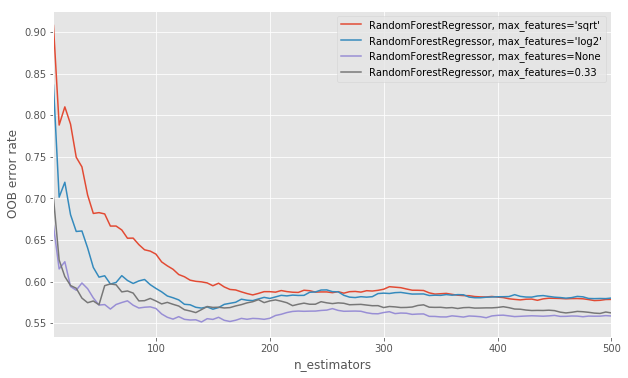

In [10]:
# Extract vars
y = df2[target_var]
X = df2[exp_vars]

# Standardise exp vars
scalar = StandardScaler()
X_scaled = pd.DataFrame(scalar.fit_transform(X), 
                        index=X.index, 
                        columns=X.columns)

# For reproducibility
rand_state = 42

# List classifiers of interest
# NB: Setting the `warm_start=True` disables parallel support, but is necessary for 
# tracking the OOB error trajectory during training
ensemble_clfs = [
    ("RandomForestRegressor, max_features='sqrt'",
        RandomForestRegressor(n_estimators=100,
                              warm_start=True, 
                              oob_score=True,
                              max_features="sqrt",
                              random_state=rand_state)),
    ("RandomForestRegressor, max_features='log2'",
        RandomForestRegressor(n_estimators=100,
                              warm_start=True, 
                              max_features='log2',
                              oob_score=True,
                              random_state=rand_state)),
    ("RandomForestRegressor, max_features=None",                  
        RandomForestRegressor(n_estimators=100,
                              warm_start=True, 
                              max_features=None,           # Default. Uses all feats
                              oob_score=True,
                              random_state=rand_state)),
    ("RandomForestRegressor, max_features=0.33",
        RandomForestRegressor(n_estimators=100,
                              warm_start=True, 
                              max_features=0.33,           # Older recommendation. Used by R
                              oob_score=True,
                              random_state=rand_state))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore
min_estimators = 10
max_estimators = 500

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1, 5):
        clf.set_params(n_estimators=i)
        clf.fit(X_scaled, y)

        # Record the OOB error 
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot
fig = plt.figure(figsize=(10,6))
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")

To pick the best parameters to use in the models below, pick the curve in the above plot which has the lowest error rate, and pick n_estimators where the curve has flattened out (or reached a minimum?)

### 4.3. Feature importances

In [11]:
# Build model using 'best' results from above
model = RandomForestRegressor(n_estimators=150,
                              warm_start=False, 
                              max_features=None,           
                              oob_score=True,
                              random_state=rand_state)
model.fit(X_scaled, y)

print ('OOB score: %.2f' % model.oob_score_)

# Get importance scores
res_df = pd.DataFrame({'importance':model.feature_importances_}, 
                      index=X.columns.values).sort_values(by='importance',
                                                          ascending=False)
res_df.head(10)

OOB score: 0.45


,importance
temp_lag1m,0.198998
tp_lake_lag1m,0.189036
temp_lag2m_av,0.058913
rel_res_time_lag3m_av,0.046489
rel_res_time,0.045133
temp_lag3m_av,0.038587
temp,0.035732
q,0.034506
pptn,0.023909
tp_catch_lag3m_av,0.022444


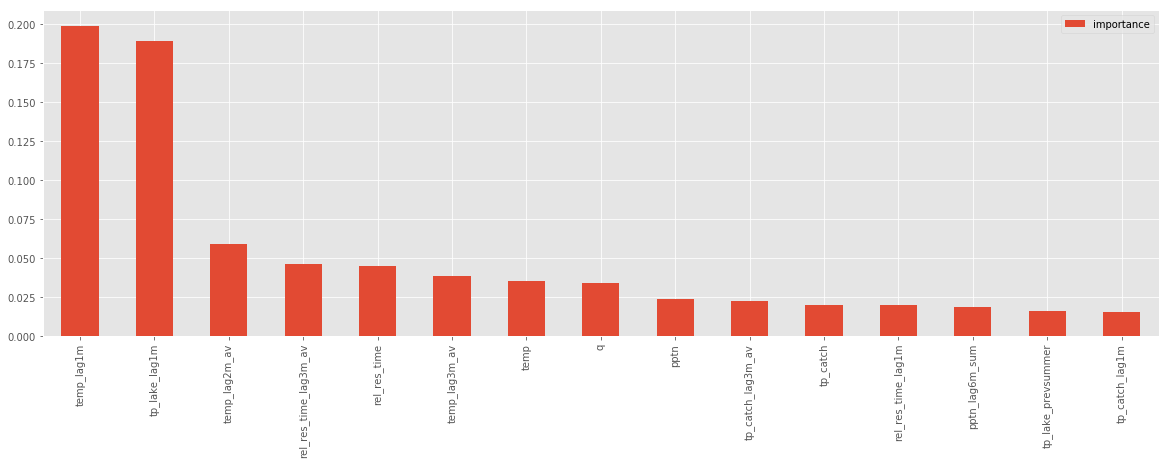

In [12]:
# Plot
res_df[:15].plot(kind='bar', figsize=(20,6))

Based on this, the most important features in Van1 (Storefjorden) are:

 * Air temperature in the previous month and, less so, average temperature over the previous 2 months
 * Average TP concentration in the lake in the previous month (i.e. autocorrelated) <br>
 * Some measure of residence time (over previous 3 months or current month)


### 4.5. Recursive feature elimination

Recursive feature elimination attempts to find the best model using subsets of the available features. This is essentially the same as "stepwise" regression, except here we're using CV to avoid overfitting (as opposed to traditional "significance testing"). In the code below, I've used out-of-sample $R^2$ as a measure of performance. The best values obtained are pretty low, but remember that out-of-sample tests are much more stringent than their within-sample equivalents. The best overall indicator of perfornmance used in this notebook is the OOB score.

**Note:** Other scoring metrics are available. Use 

    sorted(sklearn.metrics.SCORERS.keys())
    
to print a list.

In [13]:
# Build same model as above
model = RandomForestRegressor(n_estimators=150,
                              warm_start=False, 
                              max_features=None,           
                              oob_score=True,
                              random_state=rand_state)

# Feature elimination with 3-fold CV
rfecv = RFECV(estimator=model, 
              step=1, 
              cv=3, 
              scoring='r2',
              n_jobs=-1)

selector = rfecv.fit(X_scaled, y)

Optimal number of features: 5

Optimal features (in no particular order):
   rel_res_time
   temp_lag1m
   tp_lake_lag1m
   temp_lag2m_av
   rel_res_time_lag3m_av


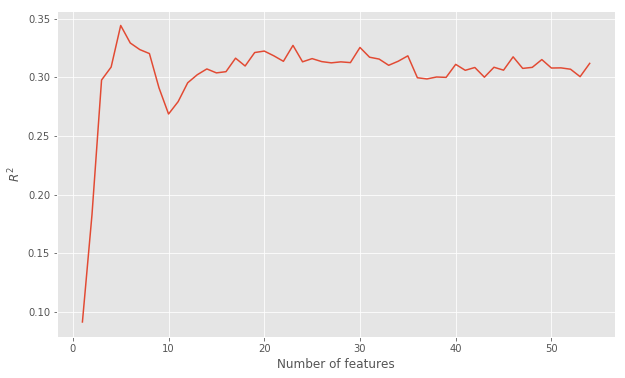

In [14]:
print('Optimal number of features: %d' % rfecv.n_features_)
print('')
print ('Optimal features (in no particular order):')
for i in np.array(exp_vars)[selector.support_]:
    print('  ', i)
    
# Plot number of features vs. cross-validation score
plt.figure(figsize=(10,6))
plt.xlabel('Number of features')
plt.ylabel('$R^2$')
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)

Use the plot to decide roughly how many features to pick before things level off. Then think about which features are likeley to contain duplicate information. Lets try a consolidated list, removing duplicated features, and see how that model performs.

In [15]:
# Reduce list of exp vars based on results above
exp_vars = ['temp_lag1m', 'rel_res_time', 'tp_lake_lag1m', 
            'rel_res_time_lag3m_av']

# Extract vars
y = df2[target_var]
X = df2[exp_vars]

# Standardise exp vars
scalar = StandardScaler()
X_scaled = pd.DataFrame(scalar.fit_transform(X), 
                        index=X.index, 
                        columns=X.columns)

# Build model using 'best' results from above
model = RandomForestRegressor(n_estimators=800,
                              warm_start=False, 
                              max_features=None,           
                              oob_score=True,
                              random_state=rand_state)
model.fit(X_scaled, y)

print ('OOB score: %.2f' % model.oob_score_)

# Get importance scores
res_df = pd.DataFrame({'importance':model.feature_importances_}, 
                      index=X.columns.values).sort_values(by='importance',
                                                          ascending=False)
res_df.head(10)

OOB score: 0.45


,importance
temp_lag1m,0.350306
tp_lake_lag1m,0.293832
rel_res_time_lag3m_av,0.178927
rel_res_time,0.176935


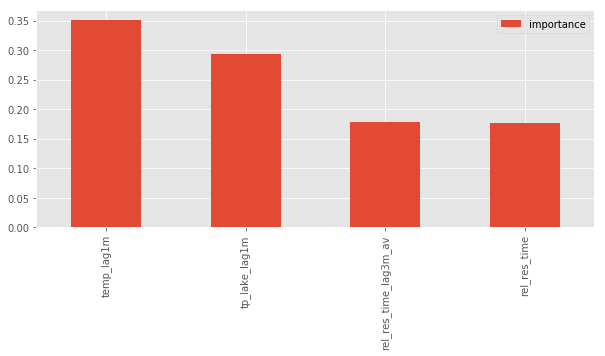

In [16]:
# Plot
res_df[:15].plot(kind='bar', figsize=(10,4))

Same again, but only with data that we would likely have available in the operational forecast

In [ ]:
# Reduce list of exp vars based on results above
exp_vars = ['temp_lag1m', 
            'rel_res_time_lag3m_av', 'rel_res_time']

# Extract vars
y = df2[target_var]
X = df2[exp_vars]

# Standardise exp vars
scalar = StandardScaler()
X_scaled = pd.DataFrame(scalar.fit_transform(X), 
                        index=X.index, 
                        columns=X.columns)

# Build model using 'best' results from above
model = RandomForestRegressor(n_estimators=150,
                              warm_start=False, 
                              max_features=None,           
                              oob_score=True,
                              random_state=rand_state)
model.fit(X_scaled, y)

print ('OOB score: %.2f' % model.oob_score_)

# Get importance scores
res_df = pd.DataFrame({'importance':model.feature_importances_}, 
                      index=X.columns.values).sort_values(by='importance',
                                                          ascending=False)
res_df.head(10)